In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt



try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
    %load_ext autoreload
    %autoreload 2



In [2]:
df_rki = cov19.data_retrieval.get_rki()

In [3]:
df_bundeslaender = cov19.filter_rki_all_bundesland(df_rki, '2020-03-10', '2020-04-13')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,4,13)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [8]:
print(new_cases_obs.shape)

(34, 16)


In [24]:
print(model.ndim_sim)
print(model.shape_sim)
print(model.new_cases_obs.shape)
print(new_cases_inferred.ndim)
print(new_cases_inferred_raw.ndim)
print(new_I_t.ndim)
print(lambda_t_log.ndim)

1
(60,)
(34,)
1
1
1
1


In [29]:
params_model = dict(new_cases_obs = new_cases_obs[:,0],
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 


with cov19.Cov19_Model(**params_model) as model:
    
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred)


()
()
()
()
()
()
()
()
()
()
()


In [30]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Average Loss = 286.63:   6%|▋         | 12681/200000 [00:16<04:06, 759.62it/s]
Convergence achieved at 12700
Interrupted at 12,699 [6%]: Average Loss = 316.36
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay, I_begin, mu, transient_len_3, transient_len_2, transient_len_1, transient_day_3, transient_day_2, transient_day_1, lambda_3, lambda_2, lambda_1, lambda_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [07:48<00:00,  8.53draws/s]
INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
The number of effective samples is smaller than 25% for some parameters.


INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock


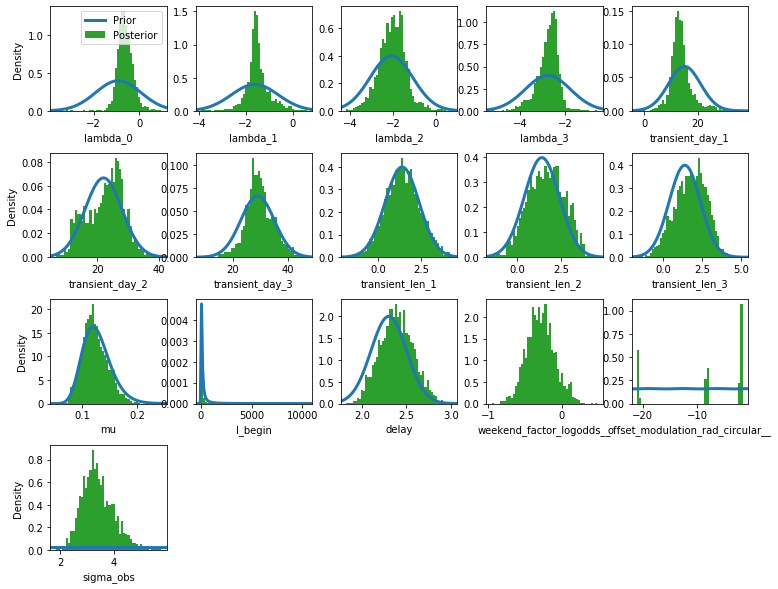

In [33]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


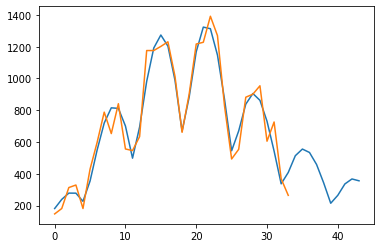

In [41]:
plt.plot(np.median(trace.new_cases, axis=0))
plt.plot(new_cases_obs[:,0])